<a href="https://colab.research.google.com/github/piotr-malek/my_python_projects/blob/main/world_bank_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hi and welcome to my project. I'm going to extract data from World Bank public API. These will be 8 health-related indicators that I'll then visualize.

## Extracting data from World Bank API

For starters I'm importing/installing the needed libraries, setting up cache not to fetch hundreds of thousands of rows of data over and over again.

Next I'm building a function that will fetch data from the Indicators API and then I'm looping through the list of indicators to get the data I need.

In [16]:
import requests
!pip install requests_cache
import requests_cache
import pandas as pd
import json

# Set up caching to limit the volume of data queried (expires after 24 hours)
requests_cache.install_cache('world_bank_cache', expire_after=86400)

def query_indicators_api(indicator):
    all_data = []
    base_url = 'https://api.worldbank.org/v2/country/all/indicator/'
    params = {'format': 'json', 'per_page': 1000}
    page = 1
    # Run through pages ones by one, fetch and add data to all_data
    while True:
        params['page'] = page
        url = f"{base_url}{indicator}"
        response = requests.get(url, params=params)

        # Check if response is successful
        if response.status_code != 200:
            print(f"Error: API request failed with the status code {response.status_code}")
            break

        data = response.json()

        # Response typically has 2 elements: metadata and actual response. The while loop breaks if
        # there are fewer than 2 elements or if there's no data in the second element (actual data)
        if len(data) < 2 or not data[1]:
            break

        # Add the response's secend element to all_data
        all_data.extend(data[1])
        page += 1

    return all_data


indicators = ['SP.DYN.TFRT.IN', 'SP.ADO.TFRT', 'SP.DYN.CBRT.IN', 'SP.DYN.CDRT.IN', 'SP.DYN.LE00.IN', 'SP.DYN.LE00.FE.IN', 'SP.DYN.LE00.MA.IN', 'SP.DYN.IMRT.IN', 'SH.DYN.MORT']

# SP.DYN.TFRT.IN - Fertility rate, total (births per woman)
# SP.ADO.TFRT - Adolescent fertility rate (births per 1,000 women ages 15-19)
# SP.DYN.CBRT.IN - Birth rate, crude (per 1,000 people)
# SP.DYN.CDRT.IN - Death rate, crude (per 1,000 people)
# SP.DYN.LE00.IN - Life expectancy at birth, total (years)
# SP.DYN.LE00.FE.IN - Life expectancy at birth, female (years)
# SP.DYN.LE00.MA.IN - Life expectancy at birth, male (years)
# SP.DYN.IMRT.IN - Mortality rate, infant (per 1,000 live births)
# SH.DYN.MORT - Mortality rate, under-5 (per 1,000 live births)

health_data = []

for indicator in indicators:
  indicator_data = query_indicators_api(indicator)
  health_data.extend(indicator_data)

health_data = json.dumps(health_data, indent=4)

# print the first 1000 characters to get an idea what the response is like
print(health_data[:1000])

[
    {
        "indicator": {
            "id": "SP.DYN.TFRT.IN",
            "value": "Fertility rate, total (births per woman)"
        },
        "country": {
            "id": "ZH",
            "value": "Africa Eastern and Southern"
        },
        "countryiso3code": "AFE",
        "date": "2023",
        "value": null,
        "unit": "",
        "obs_status": "",
        "decimal": 1
    },
    {
        "indicator": {
            "id": "SP.DYN.TFRT.IN",
            "value": "Fertility rate, total (births per woman)"
        },
        "country": {
            "id": "ZH",
            "value": "Africa Eastern and Southern"
        },
        "countryiso3code": "AFE",
        "date": "2022",
        "value": null,
        "unit": "",
        "obs_status": "",
        "decimal": 1
    },
    {
        "indicator": {
            "id": "SP.DYN.TFRT.IN",
            "value": "Fertility rate, total (births per woman)"
        },
        "country": {
            "id": "ZH",
         

Next I'm loading the data to a Python dataframe and collecting just the fields I need.

In [17]:
df = []
health_data = json.loads(health_data)

for dct in health_data:
  subset = {
      'indicator': dct['indicator']['id'],
      'country_code': dct['country']['id'],
      'country_name': dct['country']['value'],
      'year_recorded': dct['date'],
      'value': dct['value']
  }
  df.append(subset)

df = pd.DataFrame(df)

print(df.head())
print(df.info())


        indicator country_code                 country_name year_recorded  \
0  SP.DYN.TFRT.IN           ZH  Africa Eastern and Southern          2023   
1  SP.DYN.TFRT.IN           ZH  Africa Eastern and Southern          2022   
2  SP.DYN.TFRT.IN           ZH  Africa Eastern and Southern          2021   
3  SP.DYN.TFRT.IN           ZH  Africa Eastern and Southern          2020   
4  SP.DYN.TFRT.IN           ZH  Africa Eastern and Southern          2019   

      value  
0       NaN  
1       NaN  
2  4.354709  
3  4.416900  
4  4.482898  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153216 entries, 0 to 153215
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   indicator      153216 non-null  object 
 1   country_code   153216 non-null  object 
 2   country_name   153216 non-null  object 
 3   year_recorded  153216 non-null  object 
 4   value          137224 non-null  float64
dtypes: float64(1), object(4

The response includes data on countries but also regions, territories, and more. I'm only interested in countries so I had ChatGPT compile a list of only country codes and I use it to filter out all other rows.

In [18]:
country_codes = [
    'AF', 'AL', 'DZ', 'AD', 'AO', 'AG', 'AR', 'AM', 'AU', 'AT', 'AZ', 'BS', 'BH', 'BD', 'BB', 'BY', 'BE', 'BZ', 'BJ', 'BT', 'BO', 'BA', 'BW', 'BR', 'BN', 'BG', 'BF', 'BI', 'CV', 'KH', 'CM', 'CA', 'CF', 'TD', 'CL', 'CN', 'CO', 'KM', 'CG', 'CD', 'CR', 'HR', 'CU', 'CY', 'CZ', 'DK', 'DJ', 'DM', 'DO', 'EC', 'EG', 'SV', 'GQ', 'ER', 'EE', 'ET', 'FJ', 'FI', 'FR', 'GA', 'GM', 'GE', 'DE', 'GH', 'GR', 'GD', 'GT', 'GN', 'GW', 'GY', 'HT', 'HN', 'HU', 'IS', 'IN', 'ID', 'IR', 'IQ', 'IE', 'IL', 'IT', 'JM', 'JP', 'JO', 'KZ', 'KE', 'KI', 'KR', 'KW', 'KG', 'LA', 'LV', 'LB', 'LS', 'LR', 'LY', 'LI', 'LT', 'LU', 'MG', 'MW', 'MY', 'MV', 'ML', 'MT', 'MH', 'MR', 'MU', 'MX', 'FM', 'MD', 'MC', 'MN', 'ME', 'MA', 'MZ', 'MM', 'NA', 'NR', 'NP', 'NL', 'NZ', 'NI', 'NE', 'NG', 'MK', 'NO', 'OM', 'PK', 'PW', 'PA', 'PG', 'PY', 'PE', 'PH', 'PL', 'PS', 'PT', 'QA', 'RO', 'RU', 'RW', 'KN', 'LC', 'VC', 'WS', 'SM', 'ST', 'SA', 'SN', 'RS', 'SC', 'SL', 'SG', 'SK', 'SI', 'SB', 'SO', 'ZA', 'ES', 'LK', 'SD', 'SR', 'SZ', 'SE', 'CH', 'SY', 'TJ', 'TH', 'TL', 'TG', 'TO', 'TT', 'TN', 'TR', 'TM', 'TV', 'UG', 'UA', 'AE', 'GB', 'US', 'UY', 'UZ', 'VU', 'VE', 'VN', 'YE', 'ZM', 'ZW'
]


df = df[df['country_code'].isin(country_codes)]
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 109440 entries, 3136 to 153215
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   indicator      109440 non-null  object 
 1   country_code   109440 non-null  object 
 2   country_name   109440 non-null  object 
 3   year_recorded  109440 non-null  object 
 4   value          102133 non-null  float64
dtypes: float64(1), object(4)
memory usage: 5.0+ MB
None
           indicator country_code country_name year_recorded  value
3136  SP.DYN.TFRT.IN           AF  Afghanistan          2023    NaN
3137  SP.DYN.TFRT.IN           AF  Afghanistan          2022    NaN
3138  SP.DYN.TFRT.IN           AF  Afghanistan          2021  4.643
3139  SP.DYN.TFRT.IN           AF  Afghanistan          2020  4.750
3140  SP.DYN.TFRT.IN           AF  Afghanistan          2019  4.870


Over 7 thousands of rows contain null values, meaning there was no data for a given year and country. These rows won't be any useful so I can drop them.

In [19]:
df.dropna(subset=['value'], inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 102133 entries, 3138 to 153215
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   indicator      102133 non-null  object 
 1   country_code   102133 non-null  object 
 2   country_name   102133 non-null  object 
 3   year_recorded  102133 non-null  object 
 4   value          102133 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.7+ MB
None


Having a single row for each indicator, row, and country isn't particularly convenient. So I'm pivoting the table to push each indicator into a separate column.

In [20]:
df = df.pivot_table(index=['country_code', 'country_name', 'year_recorded'],
                          columns='indicator',
                          values='value').reset_index()

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country_code       11780 non-null  object 
 1   country_name       11780 non-null  object 
 2   year_recorded      11780 non-null  object 
 3   SH.DYN.MORT        10745 non-null  float64
 4   SP.ADO.TFRT        11780 non-null  float64
 5   SP.DYN.CBRT.IN     11574 non-null  float64
 6   SP.DYN.CDRT.IN     11556 non-null  float64
 7   SP.DYN.IMRT.IN     10694 non-null  float64
 8   SP.DYN.LE00.FE.IN  11448 non-null  float64
 9   SP.DYN.LE00.IN     11448 non-null  float64
 10  SP.DYN.LE00.MA.IN  11448 non-null  float64
 11  SP.DYN.TFRT.IN     11440 non-null  float64
dtypes: float64(9), object(3)
memory usage: 1.1+ MB
None


And I'm renaming each indicator into a more readable format.

In [21]:
renamed_columns = {'SP.DYN.TFRT.IN': 'fertility_rate', 'SP.ADO.TFRT': 'adolescent_fertility_rate', 'SP.DYN.CBRT.IN': 'birth_rate',
                   'SP.DYN.CDRT.IN': 'death_rate', 'SP.DYN.LE00.IN': 'life_expectancy', 'SP.DYN.LE00.FE.IN': 'female_life_expectancy',
                   'SP.DYN.LE00.MA.IN': 'male_life_expectancy', 'SP.DYN.IMRT.IN': 'infant_mortality_rate', 'SH.DYN.MORT': 'under5_mortality_rate'}
df['year_recorded'] = df['year_recorded'].astype(int)
df.rename(columns=renamed_columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country_code               11780 non-null  object 
 1   country_name               11780 non-null  object 
 2   year_recorded              11780 non-null  int64  
 3   under5_mortality_rate      10745 non-null  float64
 4   adolescent_fertility_rate  11780 non-null  float64
 5   birth_rate                 11574 non-null  float64
 6   death_rate                 11556 non-null  float64
 7   infant_mortality_rate      10694 non-null  float64
 8   female_life_expectancy     11448 non-null  float64
 9   life_expectancy            11448 non-null  float64
 10  male_life_expectancy       11448 non-null  float64
 11  fertility_rate             11440 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.1+ MB


## Data analysis and visualization

At this point I should do some checks on whether the data is clean, whether some outliers could skew the results, etc. But the main goal of this exercise was data extraction so I'll jump straight to the fun part. :)

I'm grouping the data by the year of records and displaying the mean values for each indicator.

In [22]:
yearly_data = df.groupby('year_recorded')[['under5_mortality_rate', 'adolescent_fertility_rate', 'birth_rate', 'death_rate', 'infant_mortality_rate',
                                           'female_life_expectancy', 'life_expectancy', 'male_life_expectancy', 'fertility_rate']].mean().reset_index().copy()
yearly_data


indicator,year_recorded,under5_mortality_rate,adolescent_fertility_rate,birth_rate,death_rate,infant_mortality_rate,female_life_expectancy,life_expectancy,male_life_expectancy,fertility_rate
0,1960,155.169492,102.930416,38.762560,16.083016,96.932743,55.688692,53.659497,51.731960,5.516727
1,1961,152.220168,102.061384,38.372837,15.680620,94.619298,56.307301,54.253839,52.304656,5.513527
2,1962,150.302479,101.378453,38.168554,15.398641,92.672174,56.795066,54.738347,52.781016,5.505339
3,1963,148.596774,100.368111,37.862902,15.124587,94.518333,57.101319,55.010986,53.021874,5.519005
4,1964,146.283465,99.299089,37.387016,14.742109,93.592742,57.703429,55.589643,53.577082,5.470208
...,...,...,...,...,...,...,...,...,...,...
57,2017,28.680952,47.719079,20.460952,7.711803,21.645503,74.687478,72.010643,69.447333,2.720696
58,2018,27.853968,46.681311,19.981553,7.649174,21.068254,74.902097,72.217970,69.646957,2.682696
59,2019,27.124868,45.784663,19.672344,7.628952,20.549735,75.117909,72.444437,69.881640,2.640720
60,2020,26.237037,44.701558,19.369830,8.204798,19.991534,74.575258,71.787277,69.145199,2.590222


This gives me some insights already into how data has changed over the 61 years of records. Under 5yo mortality rate has dropped more than 6-fold while infants make it through infancy over 5 times more frequently, that's absolutely fantastic.

Looking at the other stats, the birth and death rates have dropped by half and so did the fertility rate (even more for adolescents). Life expectency is up by one third, both for males and females. Health-wise, we're certainly moving forward.

Let's visualize it.

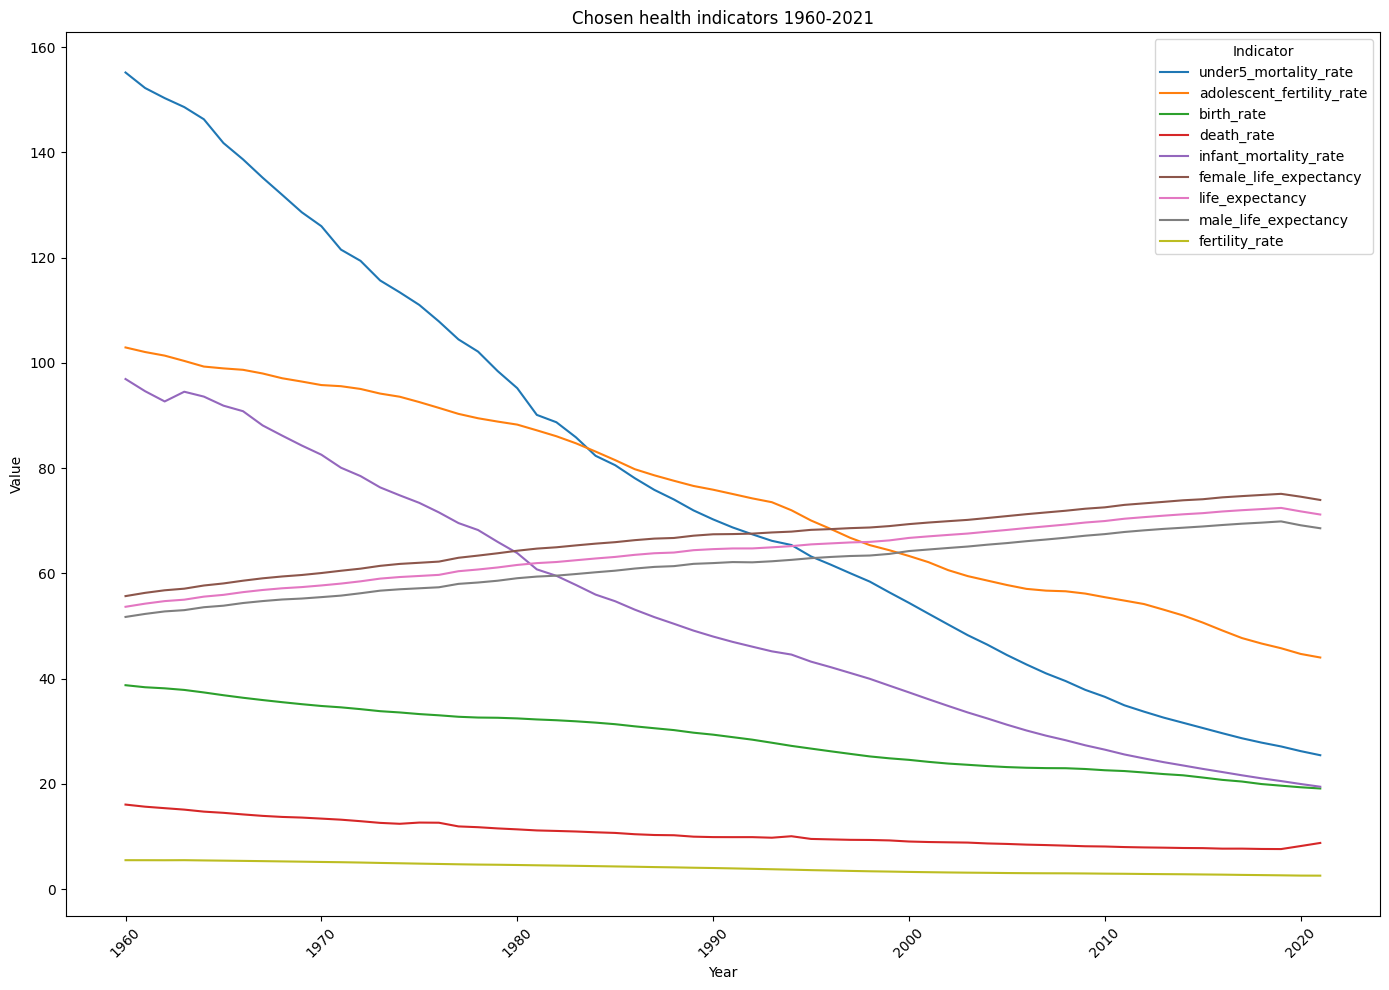

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
indicators = ['under5_mortality_rate', 'adolescent_fertility_rate', 'birth_rate', 'death_rate', 'infant_mortality_rate', 'female_life_expectancy', 'life_expectancy', 'male_life_expectancy', 'fertility_rate']

for indicator in yearly_data[indicators]:
    sns.lineplot(data=yearly_data, x='year_recorded', y=indicator, label=indicator)

plt.title('Chosen health indicators 1960-2021')
plt.xlabel('Year')
plt.ylabel('Value')

plt.xticks(rotation=45)
plt.legend(title='Indicator', loc='upper right')
plt.tight_layout()
plt.show()

The chart only confirms the trends. Interestingly, we can observe a slight dip in both death rate and all life expectancy metric in years 2019-2021. This must be related to the Covid-19 pandemic.

Next, I had my friend GPT split countries into continents and I'm drawing a separate chart for the first metric - under 5 mortality rate.

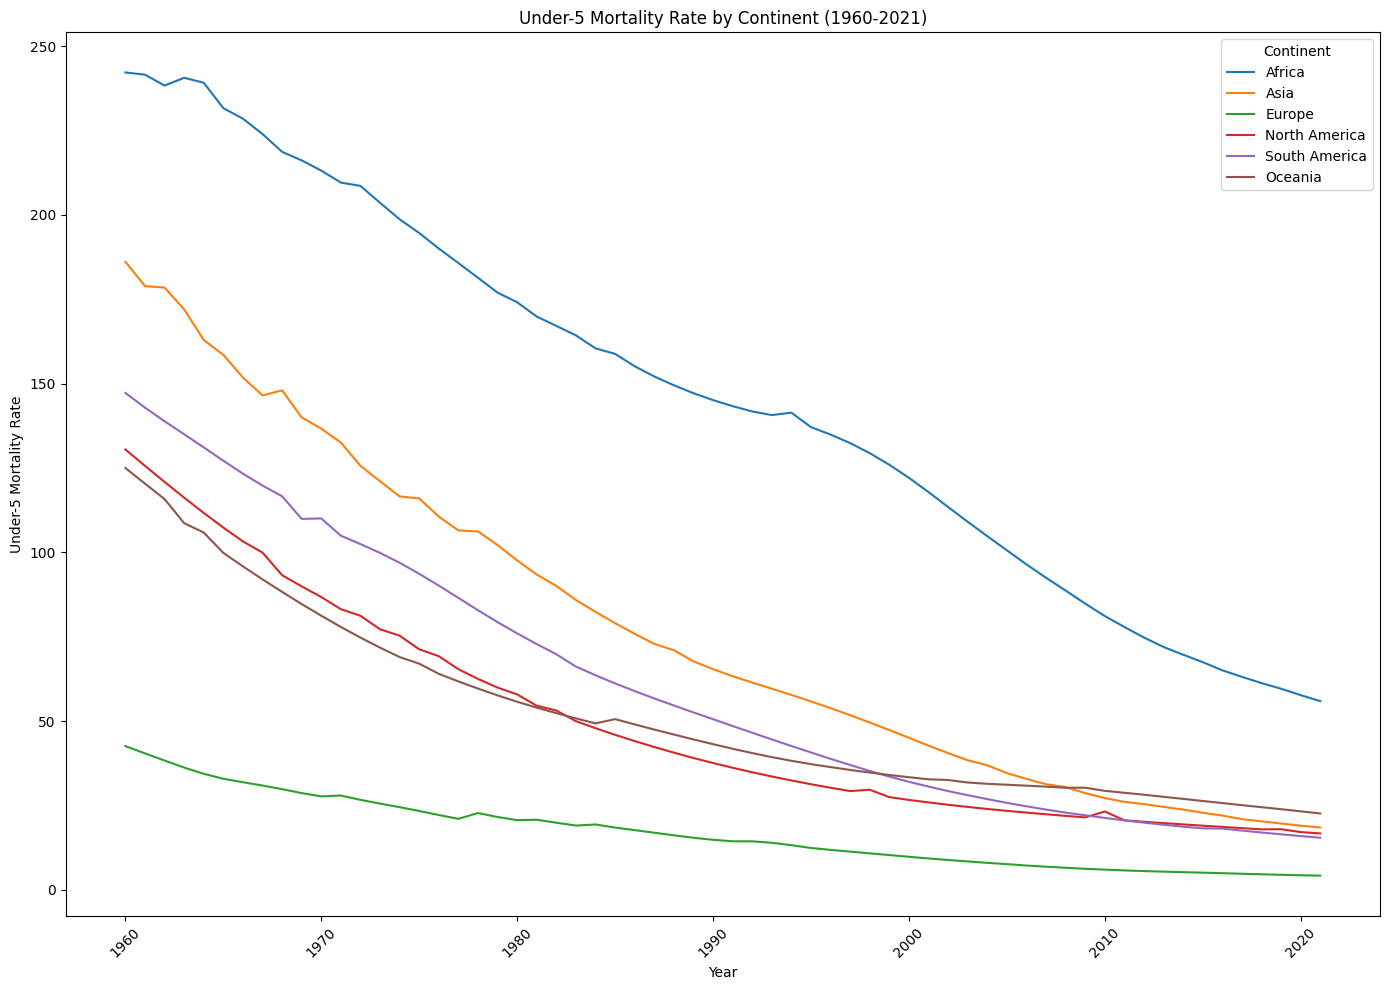

In [28]:
africa = ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CV', 'CM', 'CF', 'TD', 'KM', 'CG', 'CD', 'DJ', 'EG', 'GQ', 'ER', 'SZ', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'CI', 'KE', 'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'MA', 'MZ', 'NA', 'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'ZA', 'SS', 'SH', 'SD', 'SZ', 'TZ', 'TG', 'TN', 'UG', 'ZM', 'ZW']
asia = ['AF', 'AM', 'AZ', 'BH', 'BD', 'BT', 'BN', 'KH', 'CN', 'CY', 'GE', 'IN', 'ID', 'IR', 'IQ', 'IL', 'JP', 'JO', 'KZ', 'KW', 'KG', 'LA', 'LB', 'MY', 'MV', 'MN', 'MM', 'NP', 'KP', 'OM', 'PK', 'PH', 'PS', 'QA', 'SA', 'SG', 'KR', 'LK', 'SY', 'TW', 'TJ', 'TH', 'TR', 'TM', 'AE', 'UZ', 'VN', 'YE']
europe = ['AL', 'AD', 'AT', 'BY', 'BE', 'BA', 'BG', 'HR', 'CZ', 'DK', 'EE', 'FO', 'FI', 'FR', 'DE', 'GI', 'GR', 'HU', 'IS', 'IE', 'IT', 'XK', 'LV', 'LI', 'LT', 'LU', 'MK', 'MT', 'MD', 'MC', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RU', 'SM', 'RS', 'SK', 'SI', 'ES', 'SJ', 'SE', 'CH', 'UA', 'GB', 'VA']
north_america = ['AG', 'BS', 'BB', 'BZ', 'CA', 'CR', 'CU', 'DM', 'DO', 'SV', 'GD', 'GT', 'HT', 'HN', 'JM', 'MX', 'NI', 'PA', 'KN', 'LC', 'VC', 'TT', 'US']
south_america = ['AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'FK', 'GF', 'GY', 'PY', 'PE', 'SR', 'UY', 'VE']
oceania = ['AU', 'FJ', 'KI', 'MH', 'FM', 'NR', 'NZ', 'PW', 'PG', 'SB', 'TO', 'TV', 'VU', 'WS']

plt.figure(figsize=(14, 10))

for continent, countries in zip(['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania'], [africa, asia, europe, north_america, south_america, oceania]):
    continent_data = df[df['country_code'].isin(countries)]
    continent_mean = continent_data.groupby('year_recorded')['under5_mortality_rate'].mean()
    sns.lineplot(data=continent_mean, label=continent)

plt.title('Under-5 Mortality Rate by Continent (1960-2021)')
plt.xlabel('Year')
plt.ylabel('Under-5 Mortality Rate')

plt.xticks(rotation=45)
plt.legend(title='Continent', loc='upper right')
plt.tight_layout()
plt.show()



We can see that the indicator is decreasing for all continents albeit at different pace. Europe has been at a much lower level back in 1960 so understandably the drop is less significant.

Elsewhere, Asia used to have way too many child deaths on records but their numbers have been significantly declining, overtaking Oceania back in the 2000s. To be fair, though, the results for Austalia or New Zealand are likely close to the European average (or better) but the small island nations are sadly dragging the results down (or up in this case).

Africa is sadly the last on the list but the progress it has made since 1960s is remarkable.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country_code               11780 non-null  object 
 1   country_name               11780 non-null  object 
 2   year_recorded              11780 non-null  int64  
 3   under5_mortality_rate      10745 non-null  float64
 4   adolescent_fertility_rate  11780 non-null  float64
 5   birth_rate                 11574 non-null  float64
 6   death_rate                 11556 non-null  float64
 7   infant_mortality_rate      10694 non-null  float64
 8   female_life_expectancy     11448 non-null  float64
 9   life_expectancy            11448 non-null  float64
 10  male_life_expectancy       11448 non-null  float64
 11  fertility_rate             11440 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 1.1+ MB


Adolescent fertility rate is the only indicator that lacks null values, meaning that there are records available for every country and every year the data has been recorded. So I'm using it to determine how the results has changed between the first and the last year on records for each country separately. And then drawing a histogram to see the distribution of 'changes'.

In [30]:
indicator_change = {}

for country in country_codes:
  data1960 = df[(df['country_code'] == country) & (df['year_recorded'] == 1960)]
  data2021 = df[(df['country_code'] == country) & (df['year_recorded'] == 2021)]
  change = data2021['adolescent_fertility_rate'].iloc[0] / data1960['adolescent_fertility_rate'].iloc[0]
  indicator_change[country] = change

sorted_indicator_change = dict(sorted(indicator_change.items(), key = lambda item: item[1], reverse = True))

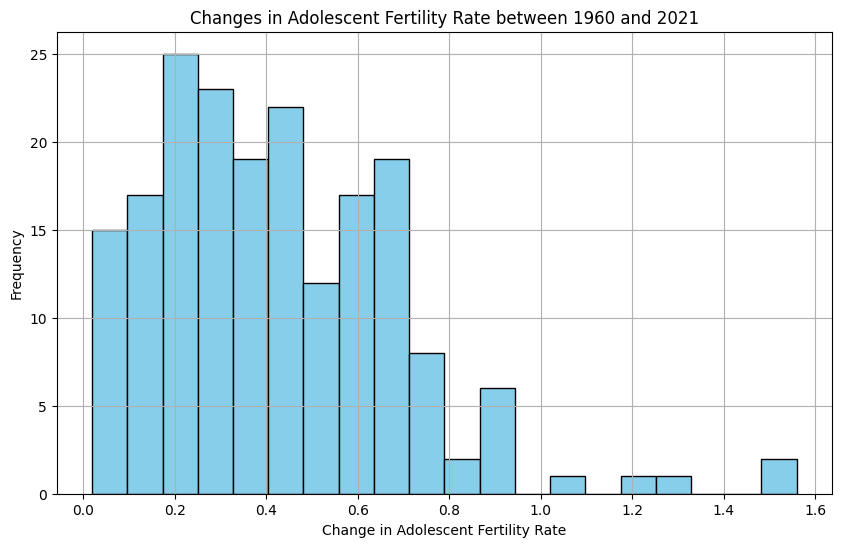

In [31]:
changes = list(sorted_indicator_change.values())

plt.figure(figsize=(10, 6))
plt.hist(changes, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Change in Adolescent Fertility Rate')
plt.ylabel('Frequency')
plt.title('Changes in Adolescent Fertility Rate between 1960 and 2021')
plt.grid(True)
plt.show()


In the vast majority of countries the fertility rate among adolescent has dropped significantly. There are also five countries where adolescent fertility rate gas grown since 1960. Let's check what they are.

In [45]:
from itertools import islice
print(dict(islice(sorted_indicator_change.items(), 5)))

{'SO': 1.5597768612521152, 'NR': 1.491061326091876, 'VN': 1.2852420043831954, 'MZ': 1.2211287732582976, 'GE': 1.054676306933662}


These are: Somalia, Nauru, Vietnam, Mozambique, and Georgia. Interesting!

There's of course a lot more insights that could be extracted and hundreds of other indicators but I'll leave that for another occasion. Thanks for your time!